## CNN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.image import rgb_to_grayscale
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
def get_image_value(path): 
    img = image.load_img(path, target_size = (28,28,3))
    img = image.img_to_array(img)
    return img/255

In [3]:
def get_conv_model_normal():
    
    inp_shape = (28,28,3)
    act = 'sigmoid'
    drop = .25 
    kernal_reg = regularizers.l2(.001)
    dil_rate = 2
    adam = Adam(.001)
    
    model = Sequential() 
    
    model.add(Conv2D(128, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg, kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
   
    model.add(Flatten())
    model.add(Dropout(drop))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 


In [4]:
train_type = 'SMOTE'

def get_samples_norm(train_type): 
    x_train = pickle.load(open(f'pickles/{train_type}_x_train.p', 'rb'))
    x_test = pickle.load(open(f'pickles/Normal_x_test.p', 'rb'))
    y_train = pickle.load(open(f'pickles/{train_type}_y_train.p', 'rb'))
    y_test = pickle.load(open(f'pickles/Normal_y_test.p', 'rb'))
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_samples_norm(train_type)
x_train = x_train.reshape(len(x_train), 28, 28, 3) #reshape from smote 

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=3)
model_checkpoint = ModelCheckpoint('models/CNN-ModelCheckpointWeights.h5', verbose = 1, save_best_only=True)

epochs = 200
batch_size = 32
normal_model = get_conv_model_normal()
normal_history = normal_model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, 
         callbacks = [early_stopping, model_checkpoint], validation_data = (x_test, y_test), verbose= 1)

Epoch 1/200
347/347 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.7259
Epoch 00001: val_loss improved from inf to 0.44255, saving model to models/CNN-ModelCheckpointWeights.h5
347/347 [==============================] - 22s 64ms/step - loss: 0.9201 - accuracy: 0.7259 - val_loss: 0.4425 - val_accuracy: 0.9105
Epoch 2/200
347/347 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.9224
Epoch 00002: val_loss improved from 0.44255 to 0.27168, saving model to models/CNN-ModelCheckpointWeights.h5
347/347 [==============================] - 22s 63ms/step - loss: 0.3566 - accuracy: 0.9224 - val_loss: 0.2717 - val_accuracy: 0.9198
Epoch 3/200
347/347 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9356
Epoch 00003: val_loss improved from 0.27168 to 0.16887, saving model to models/CNN-ModelCheckpointWeights.h5
347/347 [==============================] - 22s 63ms/step - loss: 0.2423 - accuracy: 0.9356 - val_loss: 0.1689 - val_accu

## Loss & Accuracy

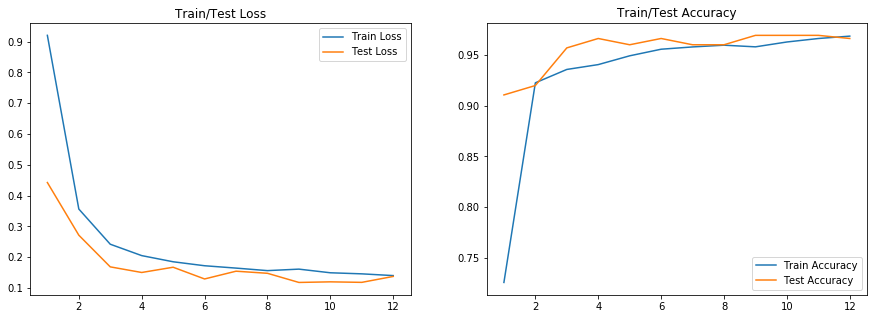

In [6]:
train_loss = normal_history.history['loss']
train_acc = normal_history.history['accuracy']
test_loss = normal_history.history['val_loss']
test_acc = normal_history.history['val_accuracy']
epochs = [i for i in range(1, len(test_acc)+1)]

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(epochs, train_loss, label = 'Train Loss')
ax[0].plot(epochs, test_loss, label = 'Test Loss')
ax[0].set_title('Train/Test Loss')
ax[0].legend()

ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
ax[1].set_title('Train/Test Accuracy')
ax[1].legend()

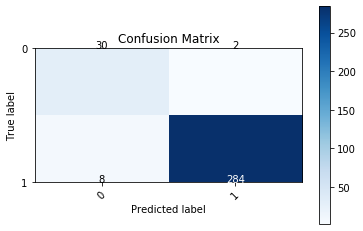

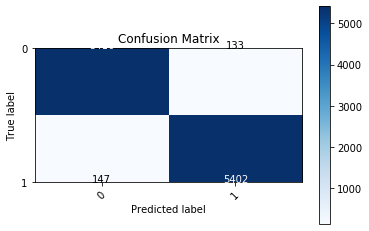

In [7]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
        # Create the basic matrix
    plt.imshow(cm,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    class_names = classes # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2. # Used for text coloring below

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    # Add a legend
    plt.colorbar()
    plt.show()
    
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-ModelCheckpointWeights.h5')

y_test_predict = normal_model.predict(x_test).ravel()
y_test_predict = np.where(y_test_predict >= .5, y_test_predict, 0)
y_test_predict = np.where(y_test_predict <= .5, y_test_predict, 1)

plot_confusion_matrix(confusion_matrix(y_test, y_test_predict), classes = [0,1])

y_train_predict = normal_model.predict(x_train).ravel()
y_train_predict = np.where(y_train_predict >= .5, y_train_predict, 0)
y_train_predict = np.where(y_train_predict <= .5, y_train_predict, 1)

plot_confusion_matrix(confusion_matrix(y_train, y_train_predict), classes = [0,1])

## Test Model
- select any picture from google and put it in the TestImages directory, then replace the path below with that of the new picture. 

In [8]:
normal_model = get_conv_model_normal()
normal_model.load_weights('models/CNN-ModelCheckpointWeights.h5') # load the best weights

for pic in os.listdir('TestImages'):
    if pic == '.DS_Store': 
        continue
    tester_img = get_image_value(f'TestImages/{pic}') 


    tester_img = np.reshape(tester_img, (1,28,28,3))
    normal_predict = normal_model.predict(tester_img).squeeze()
    if normal_predict < .5: 
        print(f'Actual: {pic}\t\tPrediction: Non-Normal\t\tValue: {normal_predict}')
    else: 
        print(f'Actual: {pic}\t\tPrediction: Normal\t\tValue; {normal_predict}')



Actual: Bacterial.jpg		Prediction: Non-Normal		Value: 0.00023016105114948004
Actual: COVID.jpg		Prediction: Non-Normal		Value: 0.05335460975766182
Actual: COVID2.jpg		Prediction: Non-Normal		Value: 6.918369308550609e-06
Actual: Fungal.jpg		Prediction: Non-Normal		Value: 0.0016880695475265384
Actual: Normal.jpg		Prediction: Non-Normal		Value: 0.007197913248091936
Actual: Normal1.jpg		Prediction: Non-Normal		Value: 0.2275019884109497
Actual: Normal2.jpg		Prediction: Non-Normal		Value: 0.00020946645236108452
Actual: normal3.jpg		Prediction: Non-Normal		Value: 0.4460262358188629
Actual: Normal4.jpg		Prediction: Non-Normal		Value: 0.0006613163277506828
Actual: Normal5.jpg		Prediction: Non-Normal		Value: 0.2275019884109497
Actual: Normal6.jpg		Prediction: Non-Normal		Value: 0.0006613163277506828
